In [ ]:
import os
import pandas as pd

directory = r"C:\Users\15801\OneDrive\桌面\NU\2025winter\data mining\project\instacart-market-basket-analysis"

all_files = os.listdir(directory)

csv_files = [f for f in all_files if f.endswith(".csv")]
print(csv_files)
dataframes = {}

for file in csv_files:
    if file not in 'user_order_amount_matrix.csv':
        file_path = os.path.join(directory, file, file)
        df = pd.read_csv(file_path)
        dataframes[file] = df
        print(f"read {file}, shape: {df.shape}")

first_file = csv_files[0] if csv_files else None
if first_file:
    print(f"\n sample DataFrame ({first_file}):")
    display(dataframes[first_file])

['aisles.csv', 'departments.csv', 'orders.csv', 'order_products__prior.csv', 'order_products__train.csv', 'products.csv', 'sample_submission.csv', 'user_order_amount_matrix.csv']
read aisles.csv, shape: (134, 2)
read departments.csv, shape: (21, 2)
read orders.csv, shape: (3421083, 7)
read order_products__prior.csv, shape: (32434489, 4)
read order_products__train.csv, shape: (1384617, 4)
read products.csv, shape: (49688, 4)
read sample_submission.csv, shape: (75000, 2)

 sample DataFrame (aisles.csv):


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# only using order_data.csv
order_df = dataframes["orders.csv"]
aisles_df = dataframes["aisles.csv"]
department_df = dataframes["departments.csv"]
train_df = dataframes["order_products__prior.csv"]
train_df = order_df.merge(train_df, on="order_id", how="inner")

train_df = train_df.drop_duplicates(subset=['user_id', 'order_id'], keep="first")

In [ ]:
order_df = dataframes["orders.csv"]
aisles_df = dataframes["aisles.csv"]
department_df = dataframes["departments.csv"]
train_df = dataframes["order_products__prior.csv"]
train_df = order_df.merge(train_df, on="order_id", how="inner")
print(train_df.shape)
train_df = train_df.drop_duplicates(subset=['user_id', 'order_id', 'product_id'], keep="first")
print(train_df.shape)
train_df = train_df.dropna()
print(train_df.shape)
product_sales = train_df.groupby("product_id")["order_id"].count().reset_index()
product_sales.rename(columns={"order_id": "total_sales"}, inplace=True)
product_sales = product_sales.sort_values(by="total_sales", ascending=False)

popular_products = product_sales[product_sales["total_sales"] >= 500]["product_id"]

user_order_counts = train_df.groupby("user_id")["order_id"].nunique().reset_index()
user_order_counts.rename(columns={"order_id": "total_orders"}, inplace=True)
active_users = user_order_counts[user_order_counts["total_orders"] >= 15]["user_id"]

train_df = train_df[(train_df["product_id"].isin(popular_products)) & (train_df["user_id"].isin(active_users))]

(32434489, 10)
(32434489, 10)
(30356421, 10)


In [ ]:
print(train_df.shape)
print(len(train_df["user_id"].unique()))
print(len(train_df["product_id"].unique()))

(19418203, 10)
65290
7907


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def df_process(df):
  scaler = StandardScaler()
  df[['order_hour_of_day', 'order_dow', 'days_since_prior_order', "order_number"]] = scaler.fit_transform(
      df[['order_hour_of_day', 'order_dow', 'days_since_prior_order', "order_number"]]
  )
  print("Finished order_hour_scaler")

  """
  df['order_amount_scaled'] = 0
  scalers={}
  for product in df["product_id"].unique():
    scaler = StandardScaler()
    product_mask = df['product_id'] == product
    df.loc[product_mask, 'order_amount_scaled'] = scaler.fit_transform(df.loc[product_mask, ['order_number']])
    scalers[product] = scaler
  print("Finished product count scaler")
  """

  minMaxScaler = MinMaxScaler(feature_range=(0, 1))
  df[['days_since_prior_order_scaled']] = minMaxScaler.fit_transform(
      df[['days_since_prior_order']]
  )
  print("days_since_prior_order_scaled finished")

  df[['days_since_prior_order_scaled']] = 1 - df[['days_since_prior_order_scaled']]
  df['weighted_order_amount'] = df['order_number'] * df['days_since_prior_order_scaled']
  return df

train_df = df_process(train_df)
user_order_amount_matrix = train_df.pivot_table(index='user_id', columns='product_id', values='weighted_order_amount', aggfunc='sum').fillna(0)

Finished order_hour_scaler
days_since_prior_order_scaled finished


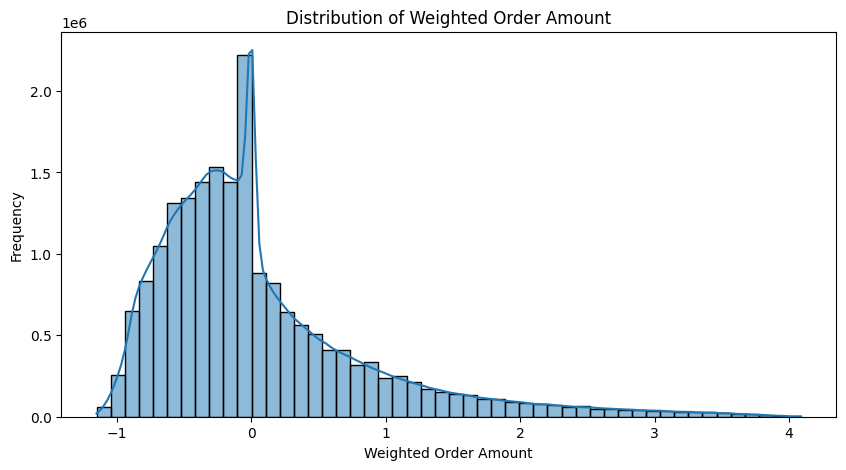

C:\Users\15801\AppData\Local\Temp\ipykernel_49536\590088606.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_counts_per_bin = train_df.groupby("weighted_order_bin")["user_id"].nunique()


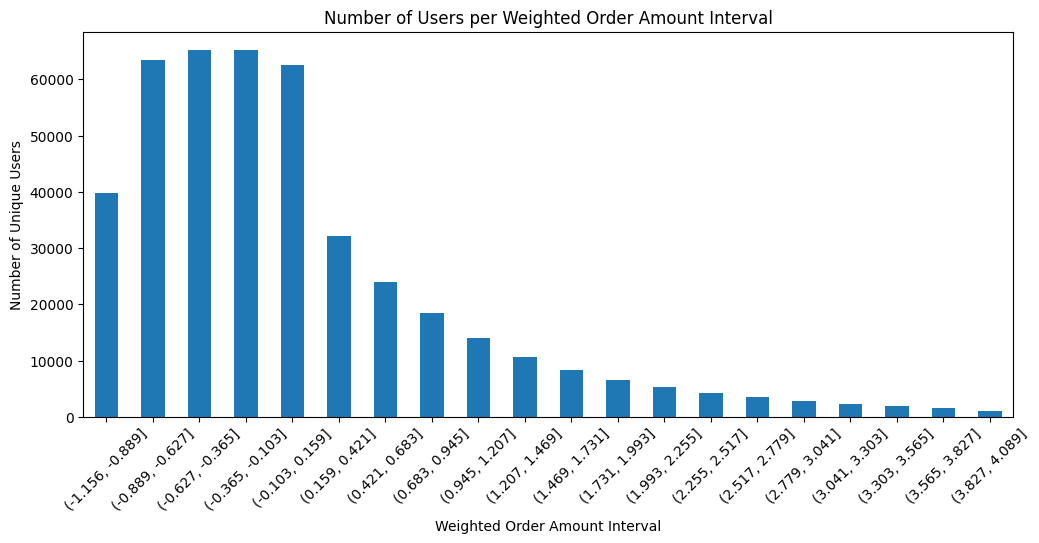

C:\Users\15801\AppData\Local\Temp\ipykernel_49536\590088606.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_counts_per_bin = train_df.groupby("weighted_order_bin")["product_id"].nunique()


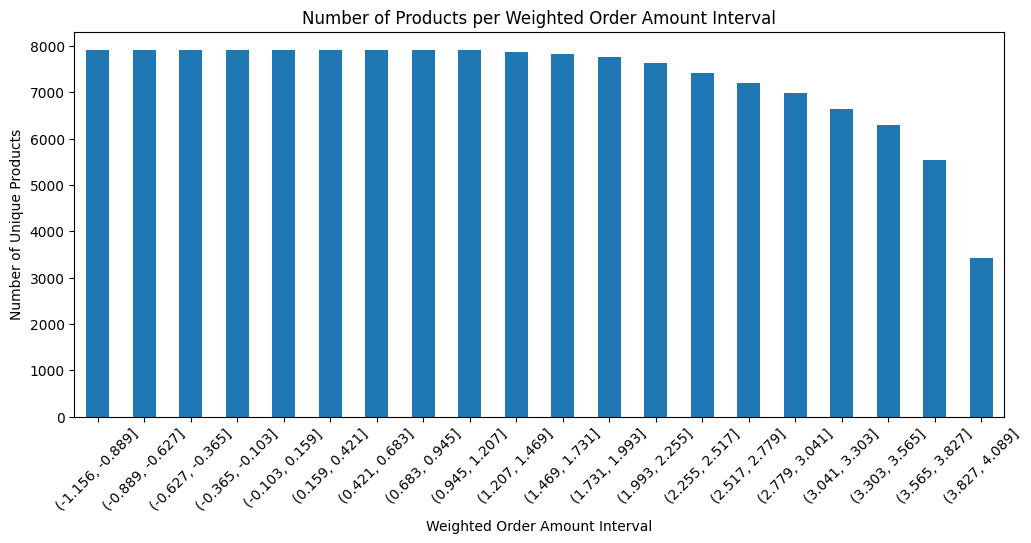

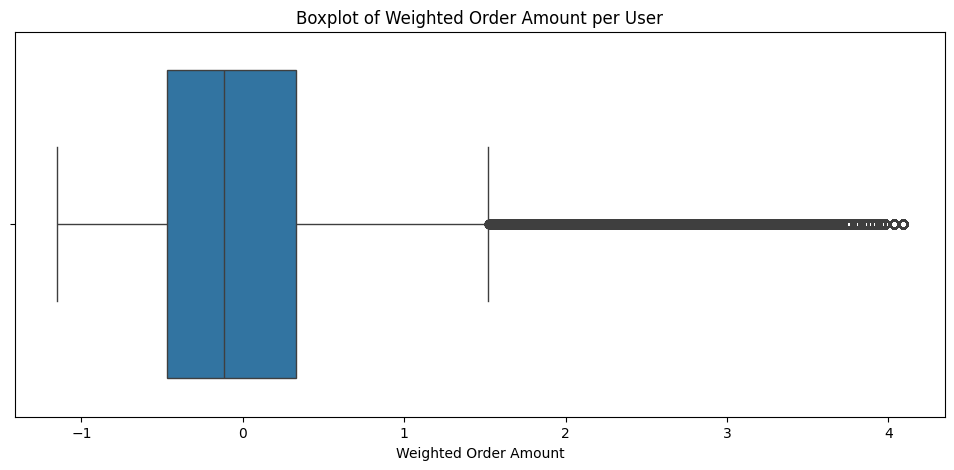

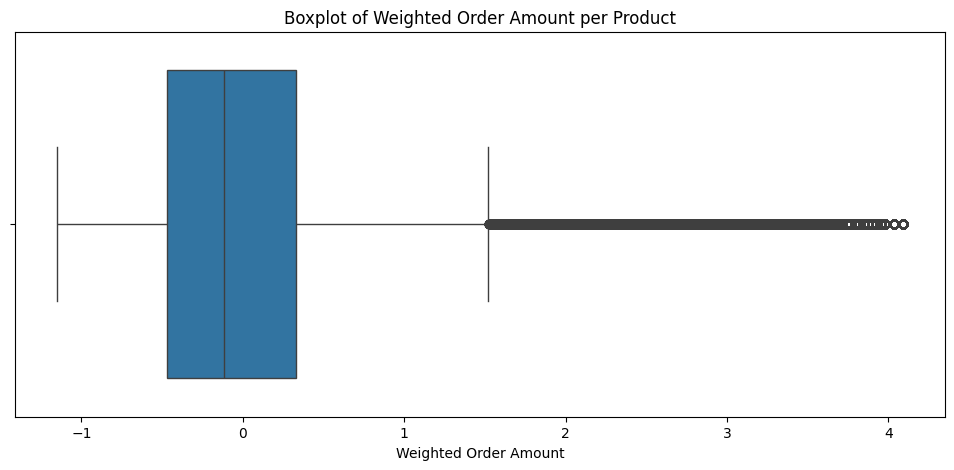

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(train_df['weighted_order_amount'], bins=50, kde=True)
plt.xlabel("Weighted Order Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Weighted Order Amount")
plt.show()

# Bin weighted_order_amount into intervals and count number of users per interval
train_df['weighted_order_bin'] = pd.cut(train_df['weighted_order_amount'], bins=20)
user_counts_per_bin = train_df.groupby("weighted_order_bin")["user_id"].nunique()

plt.figure(figsize=(12, 5))
user_counts_per_bin.plot(kind="bar")
plt.xlabel("Weighted Order Amount Interval")
plt.ylabel("Number of Unique Users")
plt.title("Number of Users per Weighted Order Amount Interval")
plt.xticks(rotation=45)
plt.show()

# Bin weighted_order_amount into intervals and count number of products per interval
product_counts_per_bin = train_df.groupby("weighted_order_bin")["product_id"].nunique()

plt.figure(figsize=(12, 5))
product_counts_per_bin.plot(kind="bar")
plt.xlabel("Weighted Order Amount Interval")
plt.ylabel("Number of Unique Products")
plt.title("Number of Products per Weighted Order Amount Interval")
plt.xticks(rotation=45)
plt.show()

# Boxplot of weighted order amount per user
plt.figure(figsize=(12, 5))
sns.boxplot(x=train_df['weighted_order_amount'])
plt.xlabel("Weighted Order Amount")
plt.title("Boxplot of Weighted Order Amount per User")
plt.show()

# Boxplot of weighted order amount per product
plt.figure(figsize=(12, 5))
sns.boxplot(x=train_df['weighted_order_amount'])
plt.xlabel("Weighted Order Amount")
plt.title("Boxplot of Weighted Order Amount per Product")
plt.show()

In [ ]:
user_order_amount_matrix.to_csv("user_order_amount_matrix.csv", index=True)

In [ ]:
user_order_amount_matrix = pd.read_csv("user_order_amount_matrix.csv", index_col=0)

user_order_amount_matrix = user_order_amount_matrix.astype(float)

print(user_order_amount_matrix.head())

           1   10   23   25   28   32   34   37   45   49  ...  49621  49622  \
user_id                                                    ...                 
7        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
15       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
17       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
21       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
24       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   

         49628  49640  49644  49652  49655  49667  49680  49683  
user_id                                                          
7          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
15         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
17         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
21         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
24         0.0    0.0    0.0    0.0    0.0 

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import numpy as np

user_order_sparse = csr_matrix(user_order_amount_matrix)

knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=10, n_jobs=-1)
knn.fit(user_order_sparse)

def recommend_users_knn(user_id, N=5):
    user_index = user_order_amount_matrix.index.get_loc(user_id)
    distances, indices = knn.kneighbors(user_order_sparse[user_index], n_neighbors=N+1)
    return user_order_amount_matrix.index[indices.flatten()[1:]]

In [ ]:
user_order_numpy = user_order_amount_matrix.to_numpy(dtype=np.float32)

knn_user = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=10, n_jobs=-1)
knn_user.fit(user_order_numpy)

def recommend_users_knn(user_id, N=5):
    if user_id not in user_order_amount_matrix.index:
        return f"User ID {user_id} not found in dataset."

    user_index = user_order_amount_matrix.index.get_loc(user_id)

    distances, indices = knn_user.kneighbors(user_order_numpy[user_index].reshape(1, -1), n_neighbors=N+1)

    neighbors = indices.flatten()[1:N+1]

    return user_order_amount_matrix.index[neighbors]

sample_user_id = user_order_amount_matrix.index[0]

try:
    recommended_users = recommend_users_knn(sample_user_id, N=5)
    print(f"Recommended users for {sample_user_id}: {recommended_users}")
except Exception as e:
    print(f"Error in recommend_users_knn: {e}")

Recommended users for 7: Index([46284, 55940, 23642, 174655, 196984], dtype='int32', name='user_id')


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

order_order_numpy = user_order_amount_matrix.to_numpy(dtype=np.float32).T

knn_order = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=10, n_jobs=-1)
knn_order.fit(order_order_numpy)

def recommend_orders_knn(order_id, N=5):
    if order_id not in user_order_amount_matrix.columns:
        return f"Order ID {order_id} not found in dataset."

    order_index = user_order_amount_matrix.columns.get_loc(order_id)

    distances, indices = knn_order.kneighbors(order_order_numpy[order_index].reshape(1, -1), n_neighbors=N+1)

    neighbors = indices.flatten()[1:N+1]

    return user_order_amount_matrix.columns[neighbors]

sample_order_id = user_order_amount_matrix.columns[0]

try:
    recommended_orders = recommend_orders_knn(sample_order_id, N=5)
    print(f"Recommended orders for {sample_order_id}: {recommended_orders}")
except Exception as e:
    print(f"Error in recommend_orders_knn: {e}")


Recommended orders for 1: Index(['19972', '30731', '7987', '19511', '14161'], dtype='object')


In [ ]:
from scipy.sparse.linalg import svds
import numpy as np

matrix = user_order_amount_matrix.to_numpy(dtype=np.float32)

U, sigma, Vt = svds(matrix, k=50)

sigma = np.diag(sigma)

predicted_matrix = np.dot(np.dot(U, sigma), Vt)

predicted_ratings = pd.DataFrame(predicted_matrix, index=user_order_amount_matrix.index, columns=user_order_amount_matrix.columns)


# Recommend orders based on predicted ratings
def recommend_svd(user_id, N=5):
    return predicted_ratings.loc[user_id].sort_values(ascending=False).head(N)

sample_user_id = user_order_amount_matrix.index[0]

try:
    recommended_orders_svd = recommend_svd(sample_user_id, N=5)
    print(f"Recommended orders for {sample_user_id}:")
    print(recommended_orders_svd)
except Exception as e:
    print(f"Error in recommend_svd: {e}")


Recommended orders for 7:
329      0.221858
17794    0.219020
196      0.190816
23909    0.156879
27086    0.152639
Name: 7, dtype: float32


In [ ]:
def hybrid_recommend(user_id, N=5, alpha=0.4, beta=0.3, gamma=0.3):
    cf_orders = recommend_users_knn(user_id, N)
    svd_orders = recommend_svd(user_id, N)

    cf_orders = list(cf_orders)
    svd_orders = list(svd_orders)

    combined_scores = {}

    for order in cf_orders:
        combined_scores[order] = combined_scores.get(order, 0) + alpha
    for order in svd_orders:
        combined_scores[order] = combined_scores.get(order, 0) + beta

    final_recommendations = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    return [order[0] for order in final_recommendations[:N]]


In [ ]:
np.random.seed(42)
users_sample = np.random.choice(user_order_amount_matrix.index.unique(), 1000, replace=False)

In [ ]:
sample_user_id = user_order_amount_matrix.index[0]
recommend_orders_knn(sample_user_id, N=5)

recommended_orders_hybrid = hybrid_recommend(sample_user_id, N=5)
print(recommended_orders_hybrid)


7
[46284, 55940, 23642, 174655, 196984]


In [ ]:
from sklearn.metrics import mean_squared_error

def evaluate_rmse(user_id, N=5):
    user_id = int(user_id)

    if user_id not in user_order_amount_matrix.index:
        return None

    true_orders = user_order_amount_matrix.loc[user_id].to_numpy()

    recommendations = hybrid_recommend(user_id, N)
    if isinstance(recommendations, str) or recommendations is None:
        return None

    predicted_scores = np.zeros_like(true_orders)
    for order_id in recommendations:
        if order_id in user_order_amount_matrix.columns:
            predicted_scores[user_order_amount_matrix.columns.get_loc(order_id)] = 1

    rmse = mean_squared_error(true_orders, predicted_scores) ** 0.5
    return rmse

rmse_scores = [evaluate_rmse(user, N=5) for user in users_sample if evaluate_rmse(user, N=5) is not None]

print(f"Average RMSE: {np.mean(rmse_scores):.4f}")



Average RMSE: 0.2381


In [ ]:
np.random.seed(42)
users_sample = np.random.choice(user_order_amount_matrix.index.unique(), 1000, replace=False)

user_recommendations = {user: hybrid_recommend(user, max(K_values)) for user in users_sample}

def evaluate_metrics(user_id, recommendations, K=5):
    user_id = int(user_id)

    if user_id not in user_order_amount_matrix.index:
        return None, None

    true_orders = np.clip(user_order_amount_matrix.loc[user_id].to_numpy(), 0, 1)

    recommendations = recommendations[:K]

    recommendations = [int(order_id) for order_id in recommendations]

    predicted_scores = np.zeros_like(true_orders)

    for order_id in recommendations:
        if order_id in user_order_amount_matrix.columns:
            predicted_scores[user_order_amount_matrix.columns.get_loc(order_id)] = 1

    hr_at_k = 1 if np.any(predicted_scores * true_orders) else 0
    ndcg_at_k = ndcg_score([true_orders], [predicted_scores]) if np.sum(true_orders) > 0 else None

    return hr_at_k, ndcg_at_k

K_values = list(range(1, 21))
hr_scores = []
ndcg_scores = []

for K in K_values:
    hr_list, ndcg_list = zip(*[evaluate_metrics(user, user_recommendations[user], K)
                               for user in users_sample if user_recommendations[user] is not None])

    hr_scores.append(np.mean([x for x in hr_list if x is not None]))
    ndcg_scores.append(np.mean([x for x in ndcg_list if x is not None]))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(K_values, hr_scores, marker='o', linestyle='-', label="HR@K")
plt.xlabel("K")
plt.ylabel("Hit Rate (HR@K)")
plt.title("HR@K Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(K_values, ndcg_scores, marker='s', linestyle='-', label="NDCG@K")
plt.xlabel("K")
plt.ylabel("NDCG Score (NDCG@K)")
plt.title("NDCG@K Curve")
plt.legend()

plt.tight_layout()
plt.show()